# **TimeGan Based Simulator**
***

### Overview 

1. **Load Data**: Reads the consolidated sensor data from a CSV file.  
2. **Preprocess Data**: Handles missing values, normalizes data, and ensures consistent 30-second intervals.  
3. **Visualize Trends**: Plots time-series data for cooling, maxigauge, and temperature to identify patterns and anomalies.  
4. **Feature Extraction**: Computes statistical metrics (mean, std, min, max) and checks data stationarity using the ADF test.  
5. **Prepare Training Data**: Constructs time-series sequences with a chosen window size (e.g., 60 timestamps).  
6. **Build TimeGAN**: Implements an LSTM-based generator and an RNN-based discriminator to learn temporal dependencies.  
7. **Train Model**: Optimizes the TimeGAN framework using adversarial learning to generate realistic synthetic time-series data.  
8. **Evaluate Results**: Assesses the quality of generated sequences by comparing them with real sensor data using statistical and visual methods.  
9. **Generate Synthetic Data**: Uses the trained TimeGAN model to produce new sensor readings that maintain the original data's statistical properties.  
10. **Visualization**: Plots real vs. synthetic data to validate the effectiveness of the model.  
---

### Step 1: Import Required Libraries

In [1]:
# Install dependencies
%pip install numpy pandas matplotlib seaborn tensorflow scikit-learn statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

***
### Step 2: Load and Preprocess Data
- Loading the consolidated CSV file.
- Handling missing values.
- Normalizing the data for better model performance.

In [5]:
# Load the dataset
data = pd.read_csv("../databases/processed_data/cd230831.csv")

# Convert the datetime column to a proper datetime format if needed
data['datetime'] = pd.to_datetime(data['datetime'])


# Display the first few rows to inspect the structure
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
             datetime  cooling_channel0  cooling_channel1  cooling_channel10  \
0 2023-08-31 00:00:30         15.596670         15.558330          15.542780   
1 2023-08-31 00:01:00         15.594503         15.558330          15.538204   
2 2023-08-31 00:01:30         15.592003         15.558330          15.532924   
3 2023-08-31 00:02:00         15.590465         15.553758          15.537758   
4 2023-08-31 00:02:30         15.589075         15.548483          15.544148   

   cooling_channel11  maxigauge_channel1  maxigauge_channel2  \
0          15.555560                0.02            0.088700   
1          15.546651                0.02            0.088713   
2          15.536371                0.02            0.088762   
3          15.549443                0.02            0.088800   
4          15.566108                0.02            0.088800   

   maxigauge_channel3  maxigauge_channel4  maxigauge_channel5  \
0           -1.480000               15

In [6]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply Z-score normalization (excluding the datetime column)
scaled_data = scaler.fit_transform(data.iloc[:, 1:])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])
scaled_df.insert(0, 'datetime', data['datetime'])  # Reinsert datetime column

# Display summary statistics after standardization
print("\nSummary Statistics after Standardization:")
print(scaled_df.describe())

# Save the preprocessed data for future use
# scaled_df.to_csv("../databases/processed_data/TimeGAN_data.csv", index=False)
print("\nData standardization completed successfully. Saved as 'TimeGAN_data.csv'.")


Summary Statistics after Standardization:
                            datetime  cooling_channel0  cooling_channel1  \
count                          69112      6.911200e+04      6.911200e+04   
mean   2023-09-11 23:58:15.000000256      8.159028e-16      1.158056e-15   
min              2023-08-31 00:00:30     -3.214294e+00     -3.056965e+00   
25%       2023-09-05 23:59:22.500000      2.029070e-02     -1.656629e-01   
50%              2023-09-11 23:58:15      3.129120e-01      1.632958e-01   
75%       2023-09-17 23:57:07.500000      4.129965e-01      5.470944e-01   
max              2023-09-23 23:56:00      1.231259e+00      2.625233e+00   
std                              NaN      1.000007e+00      1.000007e+00   

       cooling_channel10  cooling_channel11  maxigauge_channel1  \
count       6.911200e+04       6.911200e+04        6.910900e+04   
mean       -6.316667e-16      -3.053055e-15        2.673185e-18   
min        -3.228404e+00      -3.096646e+00       -1.827294e-02   
25% 

In [7]:
scaled_df.head()

,datetime,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
0,2023-08-31 00:00:30,-3.199849,-2.994182,-3.204761,-3.034381,-0.016913,-0.045074,-2.155074,-2.763639,2.137367,6.126256,3.608761,3.889064,3.756615,-0.187381
1,2023-08-31 00:01:00,-3.200409,-2.994182,-3.206055,-3.042871,-0.016913,-0.045073,-2.155055,-2.763639,2.137367,6.126256,3.608762,3.889064,3.756610,-0.187381
2,2023-08-31 00:01:30,-3.201056,-2.994182,-3.207548,-3.052668,-0.016913,-0.045070,-2.154981,-2.763639,2.137367,6.126256,3.608777,3.889071,3.756455,-0.187381
3,2023-08-31 00:02:00,-3.201453,-2.998553,-3.206181,-3.040210,-0.016913,-0.045067,-2.154925,-2.763639,2.137367,6.126256,3.608791,3.889081,3.756316,-0.187381
4,2023-08-31 00:02:30,-3.201812,-3.003597,-3.204374,-3.024329,-0.016913,-0.045067,-2.154925,-2.763639,2.137367,6.126256,3.608769,3.889145,3.756620,-0.187381


### Step 3: Data Visualization
- Plot time-series trends for cooling, maxigauge, and temperature sensors.
- Identify any existing patterns or outliers in the dataset.
- Check if the standardization process was correctly applied.

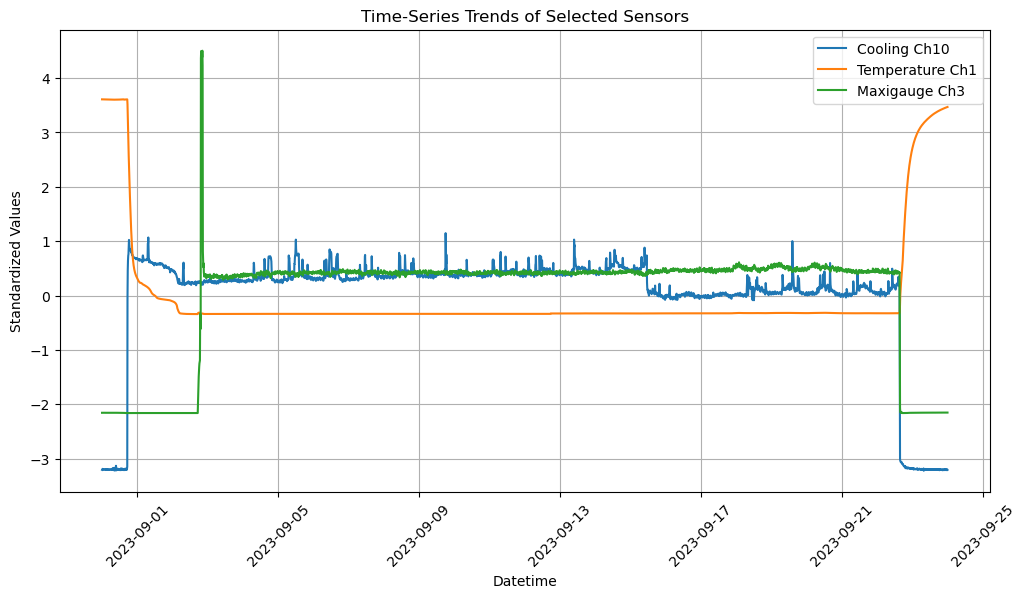

In [8]:
# Load the preprocessed dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select the chosen sensor channels
selected_columns = ['datetime', 'cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
subset_data = data[selected_columns]

# Downsample data (take one point every 10 minutes)
subset_downsampled = subset_data.iloc[::20, :]  # Select every 20th row (~10 min interval)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the selected sensor data over time
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['cooling_channel10'], label='Cooling Ch10')
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['temperature_channel1'], label='Temperature Ch1')
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['maxigauge_channel3'], label='Maxigauge Ch3')

# Formatting the plot
plt.xlabel("Datetime")
plt.ylabel("Standardized Values")
plt.title("Time-Series Trends of Selected Sensors")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Step 4: Feature Extraction
extract key statistical features from the dataset.

In [9]:
'''# Replace Inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values using forward-fill (or use mean imputation)
data.fillna(method='ffill', inplace=True)  # Forward-fill
data.fillna(method='bfill', inplace=True)  # Backward-fill (if needed)

# Drop any remaining NaN rows
data.dropna(inplace=True)

# Save the cleaned dataset (optional)
data.to_csv("../databases/processed_data/TimeGAN_data_cleaned.csv", index=False)

print("\n Data cleaned successfully. No NaN or Inf values remain.")'''

'# Replace Inf values with NaN\ndata.replace([np.inf, -np.inf], np.nan, inplace=True)\n\n# Fill NaN values using forward-fill (or use mean imputation)\ndata.fillna(method=\'ffill\', inplace=True)  # Forward-fill\ndata.fillna(method=\'bfill\', inplace=True)  # Backward-fill (if needed)\n\n# Drop any remaining NaN rows\ndata.dropna(inplace=True)\n\n# Save the cleaned dataset (optional)\ndata.to_csv("../databases/processed_data/TimeGAN_data_cleaned.csv", index=False)\n\nprint("\n Data cleaned successfully. No NaN or Inf values remain.")'

In [10]:
from statsmodels.tsa.stattools import adfuller

# Load the dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select only the relevant sensor columns
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns]

# Check for NaN and Inf values before ADF test
sensor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
sensor_data.fillna(method='ffill', inplace=True)  # Forward-fill missing values
sensor_data.fillna(method='bfill', inplace=True)  # Backward-fill if needed
sensor_data.dropna(inplace=True)  # Drop any remaining NaN values

# Perform ADF test for selected sensors
adf_results = {}
for column in sensor_data.columns:
    adf_test = adfuller(sensor_data[column])
    adf_results[column] = {'ADF Statistic': adf_test[0], 'p-value': adf_test[1]}

# Convert ADF results to a DataFrame
adf_df = pd.DataFrame.from_dict(adf_results, orient='index')

# Display ADF test results
print("\nAugmented Dickey-Fuller (ADF) Test Results for Selected Sensors:")
print(adf_df)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6468\1340927989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6468\1340927989.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sensor_data.fillna(method='ffill', inplace=True)  # Forward-fill missing values
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6468\1340927989.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data.fillna(method='ffi


Augmented Dickey-Fuller (ADF) Test Results for Selected Sensors:
                      ADF Statistic   p-value
cooling_channel10         -2.762297  0.063865
temperature_channel1      -2.635902  0.085802
maxigauge_channel3        -3.553566  0.006713


### Step 5: Prepare Training Data for TimeGAN
- Select 'cooling_channel10', 'temperature_channel1', and 'maxigauge_channel3' for training.
- Convert the dataset into sequences that TimeGAN can process.
- Define the time window (sequence length) for training.

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns].values  # Convert to numpy array

# 归一化到[-1, 1]范围
scaler = MinMaxScaler(feature_range=(-1, 1))
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 120

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# 创建训练序列
train_data = create_sequences(sensor_data_normalized, sequence_length)
# 80% 训练集，20% 测试集
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

# 检查划分后的数据形状
print("\n✅ Training & Testing Data Split Completed!")
print(f"Training Data Shape: {train_data.shape}")  # 预期: (80% of total, 60, 3)
print(f"Testing Data Shape: {test_data.shape}")  # 预期: (20% of total, 60, 3)

# Check the shape of the prepared training data
print("\n✅ Training data prepared successfully!")
print(f"Training data shape: {train_data.shape}")  # Expected output: (num_samples, sequence_length, num_features)

# Define batch size and training epochs
batch_size = 32
epochs = 10


✅ Training & Testing Data Split Completed!
Training Data Shape: (55193, 120, 3)
Testing Data Shape: (13799, 120, 3)

✅ Training data prepared successfully!
Training data shape: (55193, 120, 3)


In [12]:

# ================== 添加监督损失组件 ==================
class TimeGAN(Model):
    def __init__(self, generator, discriminator, supervisor, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.supervisor = supervisor
        
        # 定义独立的指标跟踪器
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.sup_loss_tracker = tf.keras.metrics.Mean(name="sup_loss")

    def compile(self, gen_optimizer, disc_optimizer, sup_optimizer, 
              gen_loss_fn, disc_loss_fn, sup_loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.sup_optimizer = sup_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.sup_loss_fn = sup_loss_fn

    def train_step(self, real_sequences):
        # 训练判别器
        with tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = self.generator(real_sequences, training=True)
            
            # 获取判别结果
            real_output = self.discriminator(real_sequences, training=True)
            fake_output = self.discriminator(fake_sequences, training=True)
            
            # 计算判别器损失
            disc_loss_real = self.disc_loss_fn(tf.ones_like(real_output), real_output)
            disc_loss_fake = self.disc_loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = (disc_loss_real + disc_loss_fake) / 2

        # 更新判别器
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        # 训练生成器（含监督损失）
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape:
            fake_sequences = self.generator(real_sequences, training=True)
            
            # 监督损失：预测下一个时间步
            pred_next_step = self.supervisor(fake_sequences[:, :-1, :])  # 使用前119步预测最后一步
            sup_loss = self.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step)
            
            # 对抗损失
            fake_output = self.discriminator(fake_sequences, training=False)
            gen_loss = self.gen_loss_fn(tf.ones_like(fake_output), fake_output)

            # 总损失组合
            total_gen_loss = gen_loss + 0.5 * sup_loss  # 权重可调

        # 更新生成器
        gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        
        # 更新监督器
        sup_grads = sup_tape.gradient(sup_loss, self.supervisor.trainable_weights)
        self.sup_optimizer.apply_gradients(zip(sup_grads, self.supervisor.trainable_weights))

        # 更新指标
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.sup_loss_tracker.update_state(sup_loss)
        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "sup_loss": self.sup_loss_tracker.result(),
        }

# 构建监督模型
def build_supervisor():
    inputs = Input(shape=(120, 3))
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(3))(x)  # 预测下一时间步
    return Model(inputs, outputs, name="Supervisor")

### Step 6: Implement TimeGAN (LSTM Generator + RNN Discriminator)
- LSTM-based Generator
- RNN-based Discriminator
- Embedding & Recovery Networks

In [13]:
def build_generator():
    inputs = Input(shape=(120, 3))  # 调整为120时间步
    x = LSTM(128, return_sequences=True)(inputs)  # 增加容量
    x = LSTM(64, return_sequences=True)(x)
    outputs = Dense(3, activation='tanh')(x)
    return Model(inputs, outputs, name="Generator")

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Flatten

def build_discriminator():
    inputs = Input(shape=(120, 3))
    x = GRU(128, return_sequences=True)(inputs)
    x = GRU(64, return_sequences=False)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")

discriminator = build_discriminator()
print("\n✅ Discriminator Model Summary:")
discriminator.summary()


✅ Discriminator Model Summary:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 120, 128)       │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,385 (345.25 KB)

 Trainable params: 88,385 (345.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
'''# 定义优化器
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 编译 Generator 和 Discriminator
generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)'''

"# 定义优化器\ngen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\ndisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\n\n# 编译 Generator 和 Discriminator\ngenerator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)\ndiscriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)"

In [17]:

# ==================  异常注入函数 ==================
def inject_anomalies(synthetic_data, anomaly_ratio=0.05):
    """
    注入两种类型的异常：
    1. 突然尖峰（Spike）
    2. 持续偏移（Drift）
    """
    num_sequences, seq_len, num_features = synthetic_data.shape
    num_anomalies = int(num_sequences * anomaly_ratio)
    
    # 随机选择要注入异常的序列
    anomaly_indices = np.random.choice(num_sequences, num_anomalies, replace=False)
    
    for idx in anomaly_indices:
        # 随机选择异常类型
        if np.random.rand() > 0.5:
            # 类型1：突然尖峰（持续1-3个时间步）
            spike_length = np.random.randint(1, 4)
            spike_position = np.random.randint(0, seq_len - spike_length)
            feature_idx = np.random.randint(0, num_features)
            synthetic_data[idx, spike_position:spike_position+spike_length, feature_idx] *= 5
        else:
            # 类型2：持续偏移（持续10-30个时间步）
            drift_length = np.random.randint(10, 31)
            drift_position = np.random.randint(0, seq_len - drift_length)
            feature_idx = np.random.randint(0, num_features)
            drift_value = np.random.uniform(2.0, 4.0)  # 偏移幅度
            synthetic_data[idx, drift_position:drift_position+drift_length, feature_idx] *= drift_value
    
    return synthetic_data



In [18]:
# ================== 初始化所有组件 ==================
generator = build_generator()
discriminator = build_discriminator()
supervisor = build_supervisor()

# 编译TimeGAN
timegan = TimeGAN(
    generator=generator,
    discriminator=discriminator,
    supervisor=supervisor
)

# 定义损失函数和优化器
timegan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(1e-4),
    disc_optimizer=tf.keras.optimizers.Adam(1e-4),
    sup_optimizer=tf.keras.optimizers.Adam(1e-4),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    sup_loss_fn=tf.keras.losses.MeanSquaredError()
)

# ================== 训练后生成与异常注入 ==================
# 训练完成后生成数据（示例）
synthetic_data = generator.predict(train_data[:32])  # 使用真实数据作为输入种子

# 逆归一化
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, 3)
).reshape(synthetic_data.shape)

# 注入异常
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm)

print("\n✅ 生成数据形状:", synthetic_data_denorm.shape)  # (batch_size, 120, 3)
print("✅ 包含异常的数据示例:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看第0个序列的50-54时间步的第0个特征

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step

✅ 生成数据形状: (32, 120, 3)
✅ 包含异常的数据示例:
[-0.5487251  -0.54879254 -0.5488528  -0.5489047  -0.54894775]


### Step 7: Train TimeGAN (Small Training Setup)

In [19]:
'''import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense
from tqdm import tqdm  # 导入 tqdm 进度条

# 定义优化器
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)

# 准备标签
real_labels = np.ones((batch_size, 1), dtype=np.float32)
fake_labels = np.zeros((batch_size, 1), dtype=np.float32)

# 训练循环（增加 tqdm 进度条）
for epoch in range(1, epochs + 1):
    print(f"\n🚀 Epoch {epoch}/{epochs} 开始训练 ...")
    
    # 创建进度条
    progress_bar = tqdm(range(0, len(train_data) - batch_size, batch_size), desc=f"Epoch {epoch}")

    for i in progress_bar:
        real_sequences = train_data[i:i + batch_size]
        
        # 训练判别器
        with tf.GradientTape() as disc_tape:
            fake_sequences = generator(real_sequences, training=False)
            d_real = discriminator(real_sequences, training=True)
            d_fake = discriminator(fake_sequences, training=True)
            
            d_loss_real = tf.keras.losses.binary_crossentropy(real_labels, d_real)
            d_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, d_fake)
            d_loss_total = 0.5 * (tf.reduce_mean(d_loss_real) + tf.reduce_mean(d_loss_fake))
        
        disc_grads = disc_tape.gradient(d_loss_total, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
        
        # 训练生成器
        with tf.GradientTape() as gen_tape:
            fake_sequences = generator(real_sequences, training=True)
            d_fake = discriminator(fake_sequences, training=False)
            
            g_loss = tf.keras.losses.binary_crossentropy(real_labels, d_fake)
            g_loss = tf.reduce_mean(g_loss)
        
        gen_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

        # 更新进度条信息
        progress_bar.set_postfix({"D Loss": f"{d_loss_total.numpy():.4f}", "G Loss": f"{g_loss.numpy():.4f}"})

    print(f"✅ Epoch {epoch} 结束 - D Loss: {d_loss_total:.4f} | G Loss: {g_loss:.4f}")

print("\n🎉 训练完成！")'''

'import numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, LSTM, GRU, Dense\nfrom tqdm import tqdm  # 导入 tqdm 进度条\n\n# 定义优化器\ngen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)\ndisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)\n\n# 准备标签\nreal_labels = np.ones((batch_size, 1), dtype=np.float32)\nfake_labels = np.zeros((batch_size, 1), dtype=np.float32)\n\n# 训练循环（增加 tqdm 进度条）\nfor epoch in range(1, epochs + 1):\n    print(f"\n🚀 Epoch {epoch}/{epochs} 开始训练 ...")\n\n    # 创建进度条\n    progress_bar = tqdm(range(0, len(train_data) - batch_size, batch_size), desc=f"Epoch {epoch}")\n\n    for i in progress_bar:\n        real_sequences = train_data[i:i + batch_size]\n\n        # 训练判别器\n        with tf.GradientTape() as disc_tape:\n            fake_sequences = generator(real_sequences, training=False)\n            d_real = discriminator(real_sequences

In [20]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# ================== 使用预定义的 TimeGAN 类 ==================
# 定义优化器参数（符合 TimeGAN 训练特点）
timegan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    disc_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    sup_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    sup_loss_fn=tf.keras.losses.MeanSquaredError()
)

# ================== 改进训练流程 ==================
epochs = 10
batch_size = 32
sequence_length = 120  # 每个时间序列的长度

# 处理数据批次，避免打乱时间顺序
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).shuffle(buffer_size=5, reshuffle_each_iteration=True)

# 训练循环
for epoch in range(1, epochs + 1):
    print(f"\n🚀 Epoch {epoch}/{epochs}")
    progress_bar = tqdm(train_dataset, desc="Training Progress")
    
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_sup_loss = 0.0
    
    for batch in progress_bar:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape, tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = timegan.generator(batch, training=True)

            # **修正 Supervisor 输入形状**
            fake_sequences_padded = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]], mode='CONSTANT')
            
            # 监督损失（预测未来时间步）
            pred_next_step = timegan.supervisor(fake_sequences_padded, training=True)  
            sup_loss = timegan.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])

            # 判别器损失
            d_real = timegan.discriminator(batch, training=True)
            d_fake = timegan.discriminator(fake_sequences, training=True)

            real_labels = tf.ones_like(d_real)
            fake_labels = tf.zeros_like(d_fake)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_real))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_fake))
            d_loss_total = 0.5 * (d_loss_real + d_loss_fake)

            # 生成器损失
            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_fake))

            # 总生成器损失（包含监督损失）
            total_gen_loss = g_loss + 0.5 * sup_loss

        # 计算梯度并更新判别器
        disc_grads = disc_tape.gradient(d_loss_total, timegan.discriminator.trainable_variables)
        timegan.disc_optimizer.apply_gradients(zip(disc_grads, timegan.discriminator.trainable_variables))

        # 计算梯度并更新生成器
        gen_grads = gen_tape.gradient(total_gen_loss, timegan.generator.trainable_variables)
        timegan.gen_optimizer.apply_gradients(zip(gen_grads, timegan.generator.trainable_variables))

        # 计算梯度并更新监督器
        sup_grads = sup_tape.gradient(sup_loss, timegan.supervisor.trainable_variables)
        timegan.sup_optimizer.apply_gradients(zip(sup_grads, timegan.supervisor.trainable_variables))

        # 记录损失
        total_gen_loss += total_gen_loss.numpy()
        total_sup_loss += sup_loss.numpy()
        total_disc_loss += d_loss_total.numpy()
        
        # 更新进度条
        progress_bar.set_postfix({
            "Gen Loss": f"{g_loss.numpy():.4f}",
            "Sup Loss": f"{sup_loss.numpy():.4f}",
            "Disc Loss": f"{d_loss_total.numpy():.4f}"
        })
    
    # 计算平均损失
    avg_gen_loss = total_gen_loss / len(train_dataset)
    avg_sup_loss = total_sup_loss / len(train_dataset)
    avg_disc_loss = total_disc_loss / len(train_dataset)

    print(f"✅ Epoch {epoch} 结束 - Gen Loss: {avg_gen_loss:.4f} | Sup Loss: {avg_sup_loss:.4f} | Disc Loss: {avg_disc_loss:.4f}")

print("\n🎉 训练完成！")



🚀 Epoch 1/10


Training Progress: 100%|██████████| 1724/1724 [2:16:14<00:00,  4.74s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]       


✅ Epoch 1 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 2/10


Training Progress: 100%|██████████| 1724/1724 [1:53:09<00:00,  3.94s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]


✅ Epoch 2 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 3/10


Training Progress: 100%|██████████| 1724/1724 [2:03:30<00:00,  4.30s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan] 


✅ Epoch 3 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 4/10


Training Progress: 100%|██████████| 1724/1724 [2:03:36<00:00,  4.30s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan] 


✅ Epoch 4 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 5/10


Training Progress: 100%|██████████| 1724/1724 [1:57:23<00:00,  4.09s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]


✅ Epoch 5 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 6/10


Training Progress: 100%|██████████| 1724/1724 [1:55:56<00:00,  4.04s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]


✅ Epoch 6 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 7/10


Training Progress: 100%|██████████| 1724/1724 [1:55:59<00:00,  4.04s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]


✅ Epoch 7 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 8/10


Training Progress: 100%|██████████| 1724/1724 [1:56:27<00:00,  4.05s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]


✅ Epoch 8 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 9/10


Training Progress: 100%|██████████| 1724/1724 [1:56:33<00:00,  4.06s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]


✅ Epoch 9 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🚀 Epoch 10/10


Training Progress: 100%|██████████| 1724/1724 [1:56:47<00:00,  4.06s/it, Gen Loss=nan, Sup Loss=nan, Disc Loss=nan]

✅ Epoch 10 结束 - Gen Loss: nan | Sup Loss: nan | Disc Loss: nan

🎉 训练完成！


### step 8

In [27]:
'''# ================== 生成数据并注入异常 ==================
# 生成数据时使用噪声，而非真实数据
noise = np.random.normal(size=(batch_size, sequence_length, 3))
synthetic_data = generator.predict(noise)

# 逆归一化并注入更平滑的异常
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, 3)
).reshape(synthetic_data.shape)

synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据'''

'# ================== 生成数据并注入异常 ==================\n# 生成数据时使用噪声，而非真实数据\nnoise = np.random.normal(size=(batch_size, sequence_length, 3))\nsynthetic_data = generator.predict(noise)\n\n# 逆归一化并注入更平滑的异常\nsynthetic_data_denorm = scaler.inverse_transform(\n    synthetic_data.reshape(-1, 3)\n).reshape(synthetic_data.shape)\n\nsynthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))\n\nprint("\n生成数据示例（含异常）:")\nprint(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据'

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# ================== 🚀 Step 1: 生成数据 ==================
# 生成数据时使用噪声，而非真实数据
batch_size = 32
sequence_length = 120  # 1小时数据
num_features = 3  # 3个传感器

# 生成噪声
noise = np.random.normal(size=(batch_size, sequence_length, num_features))
synthetic_data = generator.predict(noise)

# 逆归一化数据
synthetic_data_denorm = scaler.inverse_transform(
    synthetic_data.reshape(-1, num_features)
).reshape(synthetic_data.shape)

# 注入更平滑的异常
synthetic_data_with_anomalies = inject_anomalies(synthetic_data_denorm * np.random.uniform(0.9, 1.1))

print("\n✅ 生成数据示例（含异常）:")
print(synthetic_data_with_anomalies[0, 50:55, 0])  # 查看异常数据



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

✅ 生成数据示例（含异常）:
[nan nan nan nan nan]


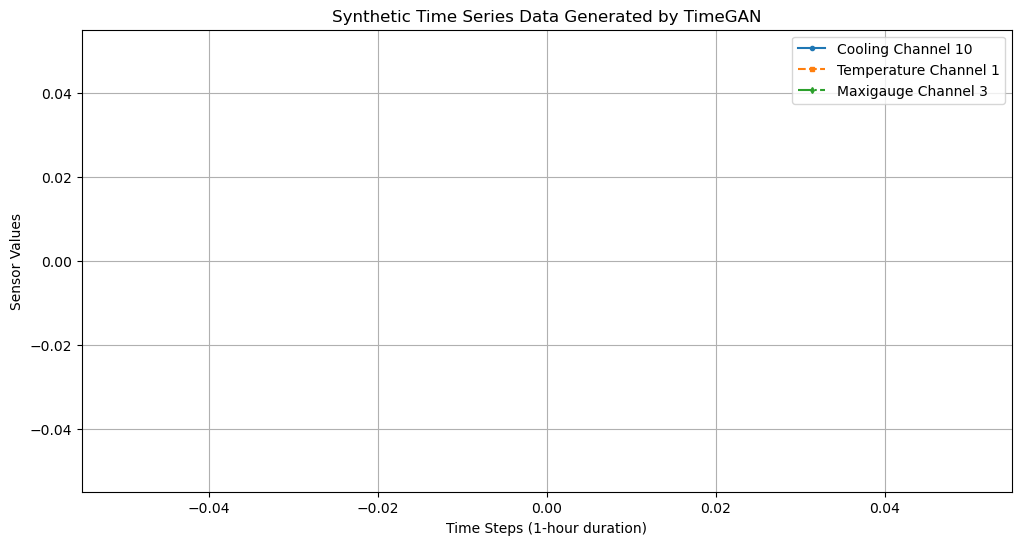


✅ 可视化图像已保存: ../databases/synthetic_time_series.png


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# ================== 🚀 Step 2: 可视化真实 vs 生成数据 ==================
# 选择一个样本进行可视化 (batch 中的第一个)
sample_idx = 0
sample_data = synthetic_data_with_anomalies[sample_idx]  # Shape: (120, 3)
time_steps = np.arange(sequence_length)  # 时间步

# 绘制 3 个特征的时间序列
plt.figure(figsize=(12, 6))
plt.plot(time_steps, sample_data[:, 0], label="Cooling Channel 10", linestyle='-', marker='o', markersize=3)
plt.plot(time_steps, sample_data[:, 1], label="Temperature Channel 1", linestyle='--', marker='s', markersize=3)
plt.plot(time_steps, sample_data[:, 2], label="Maxigauge Channel 3", linestyle='-.', marker='d', markersize=3)

# 图像美化
plt.xlabel("Time Steps (1-hour duration)")
plt.ylabel("Sensor Values")
plt.title("Synthetic Time Series Data Generated by TimeGAN")
plt.legend()
plt.grid(True)

# 保存可视化结果
plot_filename = "../databases/synthetic_time_series.png"
plt.savefig(plot_filename)
plt.show()

print(f"\n✅ 可视化图像已保存: {plot_filename}")

In [30]:
print(synthetic_data_with_anomalies)

[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 ...

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# ================== 🚀 Step 3: 保存生成数据到 CSV ==================
# 转换为 Pandas DataFrame
columns = ["Cooling Channel 10", "Temperature Channel 1", "Maxigauge Channel 3"]
simulated_df = pd.DataFrame(
    synthetic_data_with_anomalies.reshape(-1, num_features),
    columns=columns
)

# 保存 CSV 文件
csv_filename = "../databases/simulated_TimeGAN_output.csv"
simulated_df.to_csv(csv_filename, index=False)

print(f"\n✅ 生成数据已保存: {csv_filename}")


✅ 生成数据已保存: ../databases/simulated_TimeGAN_output.csv


In [35]:
'''import matplotlib.pyplot as plt

# 选择一个 batch 的第 1 组时间序列
real_sample = test_sequences[0]  # 真实数据
generated_sample = generated_sequences[0]  # 生成数据

plt.figure(figsize=(12, 6))

# 可视化 cooling_channel10
plt.subplot(3, 1, 1)
plt.plot(real_sample[:, 0], label="Real Cooling Channel", linestyle='dotted')
plt.plot(generated_sample[:, 0], label="Generated Cooling Channel")
plt.legend()

# 可视化 temperature_channel1
plt.subplot(3, 1, 2)
plt.plot(real_sample[:, 1], label="Real Temperature Channel", linestyle='dotted')
plt.plot(generated_sample[:, 1], label="Generated Temperature Channel")
plt.legend()

# 可视化 maxigauge_channel3
plt.subplot(3, 1, 3)
plt.plot(real_sample[:, 2], label="Real Maxigauge Channel", linestyle='dotted')
plt.plot(generated_sample[:, 2], label="Generated Maxigauge Channel")
plt.legend()

plt.tight_layout()
plt.show()
'''

'import matplotlib.pyplot as plt\n\n# 选择一个 batch 的第 1 组时间序列\nreal_sample = test_sequences[0]  # 真实数据\ngenerated_sample = generated_sequences[0]  # 生成数据\n\nplt.figure(figsize=(12, 6))\n\n# 可视化 cooling_channel10\nplt.subplot(3, 1, 1)\nplt.plot(real_sample[:, 0], label="Real Cooling Channel", linestyle=\'dotted\')\nplt.plot(generated_sample[:, 0], label="Generated Cooling Channel")\nplt.legend()\n\n# 可视化 temperature_channel1\nplt.subplot(3, 1, 2)\nplt.plot(real_sample[:, 1], label="Real Temperature Channel", linestyle=\'dotted\')\nplt.plot(generated_sample[:, 1], label="Generated Temperature Channel")\nplt.legend()\n\n# 可视化 maxigauge_channel3\nplt.subplot(3, 1, 3)\nplt.plot(real_sample[:, 2], label="Real Maxigauge Channel", linestyle=\'dotted\')\nplt.plot(generated_sample[:, 2], label="Generated Maxigauge Channel")\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n'